# Explaining Models with ProtoPNet and SHAP

## Initial Setup

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from deepards.dataset import ARDSRawDataset
from deepards.ppnet_push import viz_single_prototype


model_path = "saved_models/protopnet_final-epoch6-fold0.pth"
n_prototypes = 8
dataset_path = "/fastdata/deepards/unpadded_centered_with_bm-nb20-kfold.pkl"

x_train = ARDSRawDataset.from_pickle(dataset_path, False, 1.0, None, -1, None)
x_train.set_kfold_indexes_for_fold(0)
x_test = ARDSRawDataset.make_test_dataset_if_kfold(x_train)
train_loader = DataLoader(x_train, batch_size=1, shuffle=False)
test_loader = DataLoader(x_test, batch_size=1, shuffle=False)
model = torch.load(model_path).cuda().eval()

## Translate Raw Sequence Data To MLP Features

In [2]:
# For shap to work you're going to need to translate the entire dataset from raw data into final 
# prototype distances you can do this with the model.seq_forward function. Then after processing,
# roll everything up into its own tensor and you can throw that into sklearn model.
all_outputs = []
all_dists = []
all_targets = []

with torch.no_grad():
    for _, seq, __, target in train_loader:
        inputs = seq.float().cuda()
        outputs, min_distances = model.seq_forward(inputs[0])
        all_outputs.append(outputs.view(-1).unsqueeze(0).cpu().numpy())
        all_dists.append(min_distances.unsqueeze(0).cpu().numpy())
        all_targets.append(target.cpu().numpy())
        
all_outputs = np.concatenate(all_outputs, axis=0)
all_dists = np.concatenate(all_dists, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

In [3]:
all_test_features = []
all_test_dists = []
all_test_targets =[]

with torch.no_grad():
    for _, seq, __, target in test_loader:
        inputs = seq.float().cuda()
        outputs, min_distances = model.seq_forward(inputs[0])
        all_test_features.append(outputs.view(-1).unsqueeze(0).cpu().numpy())
        all_test_dists.append(min_distances.unsqueeze(0).cpu().numpy())
        all_test_targets.append(target.cpu().numpy())
        
all_test_features = np.concatenate(all_test_features, axis=0)
all_test_dists = np.concatenate(all_test_dists, axis=0)
all_test_targets = np.concatenate(all_test_targets, axis=0)

## Translate Last Layer of PyTorch Model to Scikit-Learn

We need to perform translation because Shap does not natively support linear layers from PyTorch while using a `KernelExplainer`. So we convert all information from our PyTorch classification layer to scikit-learn

In [4]:
from sklearn.neural_network import MLPClassifier

# setup a 1 layer MLP with no activation function.
mlp = MLPClassifier(hidden_layer_sizes=[], activation='identity')
# Run fit to initialize all the variables sklearn keeps hidden. We set the weights below so
# this step has no impact on final weights
mlp.fit(all_outputs[0:2], all_targets[0:2])

torch_weights = model.last_layer.weight.detach().cpu().numpy().T
# set mlp weights to the ones found in torch
mlp.coefs_ = [torch_weights]
# turn off bias
mlp.intercepts_ = [np.array([0, 0])]
# turn off final activation layer. 
mlp.out_activation_ = 'identity'

# You can sanity check you're doing it OK by checking outputs versus the pytorch model
print('Sanity Check to Make Sure MLP and Torch are the Same')
print(mlp.predict_proba([all_outputs[1]]))
with torch.no_grad():
    print(model.last_layer(torch.FloatTensor([all_outputs[1]]).cuda()).cpu().numpy())

Sanity Check to Make Sure MLP and Torch are the Same
[[13.5497675 29.000427 ]]
[[13.549767 29.000425]]


## Perform Shap Analysis

In [52]:
import pandas as pd
from scipy.special import softmax
import shap
shap.initjs()

subscript_ord_map = {n: 8320+n for n in range(10)}
# ensure that you name all the features in the model appropriately
features = []
for i in range(all_outputs.shape[1]):
    proto_n = i % n_prototypes
    # damnit theres some kind of step function here that maps 0-7 -> 0, 8-15 -> 1 ...
    breath_n = (i + n_prototypes - (i % n_prototypes))/n_prototypes - 1
    # if we want, we can use subscripting, however I've also found that it makes it more difficult to read
    proto_unicode = unichr(subscript_ord_map[proto_n])
    if len(str(breath_n)) == 1:
        breath_unicode = unichr(subscript_ord_map[breath_n])
    else:
        breath_n = str(breath_n)
        breath_unicode = unichr(subscript_ord_map[int(breath_n[0])]) + unichr(subscript_ord_map[int(breath_n[1])])
    features.append(u'prototype {},{}'.format(breath_n, proto_n))

X_train = pd.DataFrame(all_outputs, columns=features)
X_test = pd.DataFrame(all_test_features, columns=features)
# with a full dataset the KernelExplainer is dying from a SegmentationFault. This is probably being
# caused by memory issues. So for now we need to restrict it to a manageable amount of data while also
# ensuring that our model converges.
n_rand_items = 3000
idxs = np.random.choice(X_train.index, size=n_rand_items, replace=False)

explainer = shap.KernelExplainer(mlp.predict_proba, X_train.loc[idxs], link="identity")
shap_values = explainer.shap_values(X_test.iloc[0:10], nsamples=128, l1_reg="num_features(5)")
model_out = mlp.predict_proba(X_test.iloc[0:10])

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


### Proof Of Concept Shap Analysis: Using a Small Number of Reads

In [53]:
# plot the SHAP values for the 
shap.force_plot(explainer.expected_value[0], shap_values[0][0:10,:], X_test.iloc[0:10], link="identity")

## Focusing On A Single Patient

In [56]:
ground_truth.groupby('patient').patient.value_counts().sort_values()

patient            patient          
0111RPI1520160101  0111RPI1520160101     32
0137RPI1920160202  0137RPI1920160202    101
0135RPI1420160203  0135RPI1420160203    309
0033RPI0520150603  0033RPI0520150603    336
0099RPI0120151219  0099RPI0120151219    430
0108RPI0120160101  0108RPI0120160101    483
0132RPI1720160127  0132RPI1720160127    540
0102RPI0120151225  0102RPI0120151225    552
0093RPI0920151212  0093RPI0920151212    555
0133RPI0920160127  0133RPI0920160127    568
0027RPI0620150525  0027RPI0620150525    574
0026RPI1020150523  0026RPI1020150523    586
0112RPI1620160105  0112RPI1620160105    616
0125RPI1120160123  0125RPI1120160123    638
0124RPI1220160123  0124RPI1220160123    668
0122RPI1320160120  0122RPI1320160120    687
0120RPI1820160118  0120RPI1820160118    786
0021RPI0420150513  0021RPI0420150513    835
0015RPI0320150401  0015RPI0320150401    859
0098RPI1420151218  0098RPI1420151218    936
Name: patient, dtype: int64

In [163]:
from scipy.special import softmax

ground_truth = x_test.get_ground_truth_df()
X_test.index = ground_truth.index
patients = ground_truth.patient.unique()
# select a patient that isn't too computationally intense and has mix of ARDS / non-ARDS predictions
selected_pt = '0033RPI0520150603'
print("Selected Patient {}".format(selected_pt))
pt_idxs = ground_truth[ground_truth.patient == selected_pt].index

# Determine how the model would classify the patient
with torch.no_grad():
    pt_output = model.last_layer(torch.FloatTensor(X_test.loc[pt_idxs.values].values).cuda()).cpu().numpy()
pt_probs = softmax(pt_output, axis=1)

Selected Patient 0033RPI0520150603


### Basic Descriptive Stats

Aggregate predictions: ARDS, Percent Reads Classified ARDS: 0.5, N Reads: 336


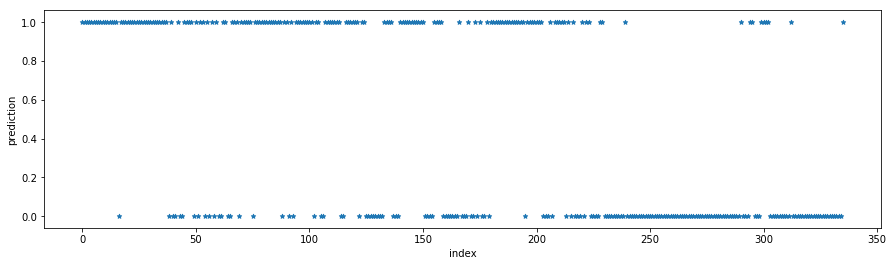

In [164]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 4]

pt_preds = pt_probs.argmax(axis=1)
prob = round(pt_preds.sum() / float(len(pt_preds)), 3)
if prob >= .5:
    prediction = 'ARDS'
else:
    prediction = 'Non-ARDS'
print("Aggregate predictions: {}, Percent Reads Classified ARDS: {}, N Reads: {}".format(prediction, prob, len(pt_preds)))
plt.scatter(np.arange(len(pt_preds)), pt_preds, s=20, marker='*')
plt.ylabel('prediction')
plt.xlabel('index')
plt.show()

### Visualizing Predictions With Shap

In [59]:
# Find shap values for all inputs. 
#
# We can set l1_reg to ensure convergence of the model. However if we set the regularization for number
# of features too high then we wont get any useful information and its possible our model will not converge.
# shap_values = explainer.shap_values(X_test.loc[pt_idxs], nsamples=72, l1_reg="num_features(3)")
shap_values = explainer.shap_values(X_test.loc[pt_idxs], nsamples=128, l1_reg="num_features(4)")

100%|██████████| 336/336 [05:33<00:00,  1.01it/s]


In [60]:
# Show force_plot for all predictions made for the patient.
#
# I think that Shap is just showing what the values are for the feature at this point, not showing 
# what the shap value is. The Shap value would be much lower in this circumstance. Also the values
# are being sorted in ascending order.
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.loc[pt_idxs], link="identity")

In [61]:
# Show force_plot for only ARDS predictions.
ards_pred_mask = pt_probs.argmax(axis=1) == 1
ards_idxs = pt_idxs[ards_pred_mask]
shap.force_plot(explainer.expected_value[1], shap_values[1][ards_pred_mask,:], X_test.loc[ards_idxs], link="identity")

In [62]:
# Now look at non-ARDS predictions
pred_mask = pt_probs.argmax(axis=1) == 0
pred_idxs = pt_idxs[ards_pred_mask]
shap.force_plot(explainer.expected_value[1], shap_values[1][pred_mask,:], X_test.loc[pred_idxs], link="identity")

### Visualizing Single Prototypes

In [173]:
#from deepards.ppnet_push import viz_single_prototype
from deepards import ppnet_push
reload(ppnet_push)

# XXX alright so this system of indexing is pretty brittle and I spent at least an hour trying 
# to debug some issues with it. Need to figure out how I can make this better.

# For example purposes, pick an ARDS predicted read and a prototype with a large Shap value
mask = np.logical_and(ards_pred_mask, np.any(shap_values[1] > 2, axis=1))
mask_idx = np.where(mask)[0]
# just pick an item randomly
rand_row_idx = np.random.choice(mask_idx)
# Select the row and values
gt_row = ground_truth[ground_truth.patient == selected_pt].iloc[rand_row_idx]
row_vals = X_test.loc[gt_row.name]
sequence_data = x_test[gt_row.name][1]
# examine the prototypes in the random row
feature_names = X_test.columns
prototypes_of_interest = feature_names[shap_values[1][rand_row_idx] > 0]

with torch.no_grad():
    protoL_input, distances = model.push_forward(torch.FloatTensor(sequence_data).cuda().unsqueeze(0))

for idx, proto in enumerate(prototypes_of_interest):
    breath_n, proto_n = proto.split(' ')[1].split(',')
    breath_n, proto_n = int(breath_n), int(proto_n)
    ppnet_push.viz_single_prototype(model, sequence_data, gt_row.y, protoL_input, distances, proto_n)
    

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# XXX Use a non-ARDS prediction to focus in on contributing prototypes based on SHAP vals.